In [230]:
import os
import time
import platform
import numpy as np
import matplotlib.pyplot as plt

import read_atlas_layer_points as rlp

In [222]:
pid_index_range= [1]
number_of_atlas = 31;

In [231]:
input_folder, main_folder, manual_seg_filename, atlas_filenames = None, None, None, None

if platform.system() == 'Windows':
    input_folder = 'C:/D/dev/data/20171204_cirrus_manual'
    main_folder = 'C:/D/dev/data/20171205_cirrus_manual_results'
    manual_seg_filename = 'C:/D/dev/Xnorm/experiments/oct/20171204_manual_segmentation/filenames.txt'
    atlas_filenames = 'C:/D/dev/Xnorm/experiments/oct/20170830_large_healthy_data_proc/cirrus_od_altas_folder_linux_iacl.txt'
elif platform.system() == 'Linux':
    input_folder = '/iacl/pg17/ja/data20171204_cirrus_manual/'
    main_folder = '/iacl/pg17/ja/data/20171205_cirrus_manual_results/'
    manual_seg_filename = '/home/ja/dev/Xnorm/experiments/oct/20171204_manual_segmentation/filenames.txt'
    atlas_filenames = '/home/ja/dev/Xnorm/experiments/oct/20170830_large_healthy_data_proc/cirrus_od_altas_folder_linux_iacl.txt'

pids, image_prefixes = rlp.read_manual_segmentation_oct_files(manual_seg_filename)
atlas_folders, atlas_subfolders = rlp.read_atlas_images_files(atlas_filenames)

#print('PID: {}\nImagePrefixes:{}'.format(pids, image_prefixes))
#print('Atlas folders:{}\nAtlas subfolders:{}'.format(atlas_folders, atlas_subfolders))

In [232]:
shuffle=False
used_pids = []
for idx in pid_index_range: used_pids.append(pids[idx])    

deformed_layer_shuffle_points4pids = rlp.get_layer_points_for_pids(used_pids, 
                                    atlas_subfolders, shuffle, main_folder, number_of_atlas)

Using 31 atlases


In [233]:
fname = '%s_flatten_result.csv' % image_prefixes[pid_index_range[0]]
filename = os.path.join(input_folder, fname)
#print(filename)
reference_labeled_points = rlp.read_layer_points(filename, shuffle)

In [234]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

class Dataset:
    def __init__(self, data_points, reference_labeled_points, label, val_frac=0.5,\
                 do_normalize=True, num_pnt_per_boundary = 512*128):
        
        self.input_dim = num_pnt_per_boundary*2
        self.output_dim = num_pnt_per_boundary
        
        train_data = data_points[label]
        test_data = reference_labeled_points[label]
        
        self.scaler = MinMaxScaler().fit(np.concatenate((train_data, test_data)))
        #print('Scaler mean: ', std_scaler.mean_, ' scale: ', std_scaler.scale_)
        train_data_scaled = self.scaler.fit_transform(train_data)
        test_data_scaled = self.scaler.fit_transform(test_data)
        #print('Train data size ', train_data_scaled.shape)
        #print('Original test data: \n', test_data[10:12, :])
        #print('\nScaled test data: \n', test_data_scaled[10:12, :])
        #print('\nUnscaled test data: \n', self.scaler.inverse_transform(test_data_scaled[10:12, :]))
        #y_scaler.inverse_transform(predicted)
        
        
        self.train_yz = train_data_scaled[:, 1:].reshape((-1, self.input_dim))
        self.train_x = train_data_scaled[:,0].reshape((-1, self.output_dim))
        print('Train yz shape ', self.train_yz.shape, ' train x shape ', self.train_x.shape)
        
        self.num_ref_points = test_data_scaled.shape[0]
        if val_frac > 1e-8:
            split_idx = int(number_of_reference_points*(1 - val_frac))

            self.test_yz, self.valid_yz = test_data_scaled[:split_idx, 1:].reshape((-1, 1)),\
                                          test_data_scaled[split_idx:, 1:].reshape((-1, 1))
            self.test_x, self.valid_x = test_data_scaled[:split_idx, 0], \
                                        test_data_scaled[split_idx:, 0]
        else:
            self.test_yz, self.valid_yz = None, test_data_scaled[:, 1:].reshape((1,- 1))
            self.test_x, self.valid_x = None, test_data_scaled[:, 0].reshape((1,- 1))        
            
        print('Validation yz shape ', self.valid_yz.shape, ' validation x shape ', self.valid_x.shape)
        
    def batches(self, batch_size):
        n_batches = len(self.train_x)//batch_size
        for ii in range(0, len(self.train_x), batch_size):
            yz = self.train_yz[ii:ii+batch_size, :]
            x = self.train_x[ii:ii+batch_size]
            
            yield yz, x

In [236]:
# data
dataset = Dataset(deformed_layer_shuffle_points4pids[used_pids[0]],
                  reference_labeled_points, '1', val_frac=0.0, do_normalize=True)
print(type(dataset.train_x))
print(dataset.scaler)

Train yz shape  (31, 131072)  train x shape  (31, 65536)
Validation yz shape  (1, 131072)  validation x shape  (1, 65536)
<class 'numpy.ndarray'>
MinMaxScaler(copy=True, feature_range=(0, 1))


In [238]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2, l1, l1_l2

In [224]:
from keras.callbacks import History, ModelCheckpoint, CSVLogger, EarlyStopping
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

kernel_reg=None

def base_model(num_hidden_units, in_dim, out_dim, dropouts=[], lr=0.01):
    """
        Number of hidden units, except the output layer: list, tuple or int
    """
    model = Sequential()
    model.add(Dense(num_hidden_units[0], input_dim=in_dim, \
                    activation='relu', kernel_initializer='glorot_uniform'))#,\
                    #kernel_regularizer=l2(0.0001)))
    if dropouts and dropouts[0]: model.add(Dropout(dropouts[0]))
    if len(num_hidden_units) > 1: 
        model.add(Dense(num_hidden_units[1], input_dim=in_dim, activation='relu', kernel_initializer='glorot_uniform'))
    if len(dropouts) > 1: model.add(Dropout(dropouts[1]))
       
    model.add(Dense(out_dim, kernel_initializer='glorot_uniform'))
    
    model.compile(loss='mean_squared_error', optimizer = Nadam())
    #model.compile(loss='mean_squared_error', 
    #              optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True))
    return model

#seed = 7
#np.random.seed(seed)

In [227]:
# params
epochs = 500
batch_size = 10
num_hiddens = [20, 10]
dropouts =[]#[0, 0.1]
input_dim, output_dim = 131072, 65536
lr = 0.001
print('Input dim ', dataset.train_yz.shape, ' out dim ', output_dim)
# model
model = base_model(num_hiddens, input_dim, output_dim, dropouts, lr)
model.summary()

# Note:'weights.best_ndam.hdf5' & 'training_log_nadam.log' for d10 d1, epochs 500, batch_size 50000
# Affix name for log files
affix = ''.join([ 'd%d_' % n for n in num_hiddens])
affix += ('epch%d_btchsz%d' % (epochs,batch_size))
if dropouts: affix += '_drp'
affix +=''.join(['_%0.2f' % d for d in dropouts])
#affix += '_l2_0.0001'
best_params_file = os.path.join(main_folder, 'save_weights', 'weights.best_ndam_%s.hdf5' % affix)
#best_params_file = os.path.join(main_folder, \
#                                'save_weights', 'weights.best_sgd%f_%s.hdf5' % (lr, affix))
print('Best params file: ', best_params_file)
log_file = os.path.join(main_folder, 'save_weights', 'training_log_nadam_%s.log' % affix)
#log_file = os.path.join(main_folder, 'save_weights', 'training_log_sgd%f_%s.log' % (lr, affix))
print('Log file: ', log_file)

Input dim  (31, 131072)  out dim  65536
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_149 (Dense)            (None, 20)                2621460   
_________________________________________________________________
dense_150 (Dense)            (None, 10)                210       
_________________________________________________________________
dense_151 (Dense)            (None, 65536)             720896    
Total params: 3,342,566.0
Trainable params: 3,342,566
Non-trainable params: 0.0
_________________________________________________________________
Best params file:  C:/D/dev/data/20171205_cirrus_manual_results\save_weights\weights.best_ndam_d20_d10_epch500_btchsz10.hdf5
Log file:  C:/D/dev/data/20171205_cirrus_manual_results\save_weights\training_log_nadam_d20_d10_epch500_btchsz10.log


In [219]:
from keras.callbacks import History, ModelCheckpoint, CSVLogger, EarlyStopping
from keras.optimizers import Nadam

# Define callback
checkpointer = ModelCheckpoint(filepath=best_params_file, verbose=1, save_best_only=True)
history = History()
csv_logger = CSVLogger(log_file)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0,
                              patience=10, verbose=0, mode='auto')

## TODO: Train the model
model.fit(dataset.train_yz, dataset.train_x, validation_data=(dataset.valid_yz, dataset.valid_x),
          epochs=epochs, batch_size=batch_size, verbose=2,
          callbacks=[history, checkpointer, csv_logger, early_stopping])

## TODO: Save the model as model.h5
#model.save('my_model.h5')

Train on 31 samples, validate on 1 samples
Epoch 1/500
Epoch 00000: val_loss improved from inf to 0.09978, saving model to C:/D/dev/data/20171205_cirrus_manual_results\save_weights\weights.best_ndam_d20_d15_epch500_btchsz10_drp_0.00_0.10.hdf5
3s - loss: 0.6968 - val_loss: 0.0998
Epoch 2/500
Epoch 00001: val_loss improved from 0.09978 to 0.03540, saving model to C:/D/dev/data/20171205_cirrus_manual_results\save_weights\weights.best_ndam_d20_d15_epch500_btchsz10_drp_0.00_0.10.hdf5
1s - loss: 0.0714 - val_loss: 0.0354
Epoch 3/500
Epoch 00002: val_loss improved from 0.03540 to 0.02363, saving model to C:/D/dev/data/20171205_cirrus_manual_results\save_weights\weights.best_ndam_d20_d15_epch500_btchsz10_drp_0.00_0.10.hdf5
1s - loss: 0.0293 - val_loss: 0.0236
Epoch 4/500
Epoch 00003: val_loss did not improve
1s - loss: 0.0481 - val_loss: 0.0673
Epoch 5/500
Epoch 00004: val_loss did not improve
1s - loss: 0.0692 - val_loss: 0.0687
Epoch 6/500
Epoch 00005: val_loss did not improve
1s - loss: 0.0

Min val loss  ['0.0232677701861', '0.0197085998952', '0.0180404502898', '0.0230231005698', '0.0236176904291', '0.0230821147561', '0.0233294405043', '0.0234599858522', '0.0197727642953', '0.0362394973636', '0.0218565892428', '0.0233096852899', '0.0173328183591', '0.0140232332051', '0.0141467982903', '0.0149905784056', '0.016478644684', '0.0176249947399', '0.0379370227456']


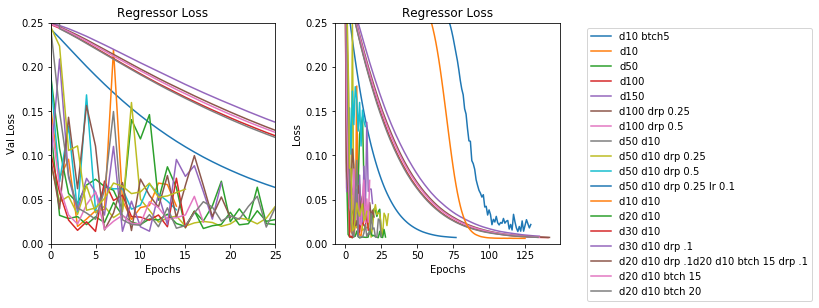

In [201]:
%matplotlib inline

fnames = ['training_log_nadam_d10_epch500_btchsz5.log',
          'training_log_nadam_d10_epch500_btchsz10.log',
          'training_log_nadam_d50_epch500_btchsz10.log',
          'training_log_nadam_d100_epch500_btchsz10.log',
          'training_log_nadam_d150_epch500_btchsz10_drp.log',
          'training_log_nadam_d100_epch500_btchsz10_drp_0.25.log',
          'training_log_nadam_d100_epch500_btchsz10_drp_0.50.log',
          'training_log_nadam_d50_d10_epch500_btchsz10.log',
          'training_log_nadam_d50_d10_epch500_btchsz10_drp_0.25.log',
          'training_log_nadam_d50_d10_epch500_btchsz10_drp_0.50.log',
          'training_log_sgd0.100000_d50_d10_epch500_btchsz10_drp_0.25.log',
          'training_log_nadam_d10_d10_epch500_btchsz10.log',
          'training_log_nadam_d20_d10_epch500_btchsz10.log', 
          'training_log_nadam_d30_d10_epch500_btchsz10.log',
          'training_log_nadam_d30_d10_epch500_btchsz10_drp_0.10.log',
          'training_log_nadam_d20_d10_epch500_btchsz10_drp_0.10.log',
          'training_log_nadam_d20_d10_epch500_btchsz15_drp_0.10.log',
          'training_log_nadam_d20_d10_epch500_btchsz15.log',
          'training_log_nadam_d20_d10_epch500_btchsz20.log']

legend = ['d10 btch5', 'd10', 'd50', 'd100', 'd150', \
          'd100 drp 0.25', 'd100 drp 0.5', 'd50 d10', \
          'd50 d10 drp 0.25', 'd50 d10 drp 0.5', 'd50 d10 drp 0.25 lr 0.1',\
          'd10 d10', 'd20 d10', 'd30 d10', 'd30 d10 drp .1', 'd20 d10 drp .1'\
          'd20 d10 btch 15 drp .1', 'd20 d10 btch 15', 'd20 d10 btch 20']

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
min_val_loss = []
for fname in fnames:
    #print(fname)
    log_file = os.path.join(main_folder, 'save_weights', fname)
    nb_epochs, loss, val_loss = rlp.read_log_file(log_file)
    min_val_loss.append(min(val_loss))
    ax1.plot(nb_epochs, val_loss)
    ax2.plot(nb_epochs, loss)
ax1.set_title('Regressor Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Val Loss')
ax1.set_ylim(0, 0.25)
ax1.set_xlim(0, 25)
#ax1.legend(legend, loc='upper right')

ax2.set_title('Regressor Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_ylim(0, 0.25)
ax2.legend(legend, bbox_to_anchor=(1.1, 1), loc=2)
plt.tight_layout(pad=1, w_pad=1, h_pad=1.2)
print('Min val loss ', min_val_loss)

In [229]:
# load optimal model
filename = os.path.join(main_folder, 'save_weights', 'weights.best_ndam_d20_d10_epch500_btchsz10.hdf5')
model.load_weights(filename)

In [255]:
#fname = '%s_seg_manual_ARL_flatten_result.csv' % image_prefixes[pid_index_range[0]]
fname = '%s_flatten_result.csv' % image_prefixes[pid_index_range[0]]
filename = os.path.join(input_folder, fname)
#print(filename)
target_labeled_points = rlp.read_layer_points(filename, shuffle)
target_points = target_labeled_points['1']
scaled_target_points = dataset.scaler.fit_transform(target_points)
scaled_target_yz = scaled_target_points[:, 1:].reshape((1,- 1))
scaled_target_x = scaled_target_points[:, 0].reshape((1,- 1))
print('Original target points ', target_points[:5])
print('Scale target points ', scaled_target_points[:5])
print('Unscale target points ', dataset.scaler.inverse_transform(scaled_target_points[:5]))

Original target points  [[ 0.773018    0.          0.        ]
 [ 0.772479    0.0117      0.        ]
 [ 0.77207297  0.0234      0.        ]
 [ 0.77186102  0.0351      0.        ]
 [ 0.77179402  0.0468      0.        ]]
Scale target points  [[ 0.77243137  0.          0.        ]
 [ 0.76861286  0.00195695  0.        ]
 [ 0.7657361   0.00391389  0.        ]
 [ 0.76423454  0.00587084  0.        ]
 [ 0.76376009  0.00782779  0.        ]]
Unscale target points  [[ 0.773018    0.          0.        ]
 [ 0.772479    0.0117      0.        ]
 [ 0.77207297  0.0234      0.        ]
 [ 0.77186102  0.0351      0.        ]
 [ 0.77179402  0.0468      0.        ]]


In [256]:
predict_x = model.predict(scaled_target_yz)
print('Predict ', predict_x, ' target ', scaled_target_x)

Predict  [[ 0.69952792  0.70161319  0.667548   ...,  0.33162478  0.33526164
   0.34523147]]  target  [[ 0.77243137  0.76861286  0.7657361  ...,  0.90901375  0.9144969
   0.9182024 ]]
